<a href="https://colab.research.google.com/github/Harshita879/disease_severity/blob/main/disease_severity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers torch pandas numpy scikit-learn matplotlib seaborn

In [5]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import re

In [6]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [35]:
# Load data
from google.colab import files
uploaded = files.upload()

Saving M3S-Radiology-Reports.csv to M3S-Radiology-Reports (3).csv


TASK 2: BioClinicalBERT Classification

Using device: cpu

===== TASK 2: Document-Level Severity Classification =====

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   text                490 non-null    object
 1   severity_label      490 non-null    object
 2   severity_indicator  490 non-null    object
dtypes: object(3)
memory usage: 11.6+ KB
None

Sample of data:
                                                text severity_label  \
0  [**2149-11-26**] 11:07 AM  MR-ANGIO HEAD; MR H...           none   
1  [**2149-11-26**] 11:07 AM  MR-ANGIO HEAD; MR H...           none   
2  [**2149-11-26**] 11:07 AM  MR-ANGIO HEAD; MR H...           none   
3  [**2149-11-26**] 11:07 AM  MR-ANGIO HEAD; MR H...           none   
4  [**2149-11-26**] 11:07 AM  MR-ANGIO HEAD; MR H...           none   

  severity_indicator  
0               none  
1               none  
2   

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Starting training...

Epoch 1/3


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Average training loss: 0.6572
Validation accuracy: 0.9286
Saved best model with accuracy: 0.9286

Epoch 2/3


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Average training loss: 0.3374
Validation accuracy: 0.9286

Epoch 3/3


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Average training loss: 0.3028
Validation accuracy: 0.9286

Performing final evaluation...

Final Test Accuracy: 0.9286


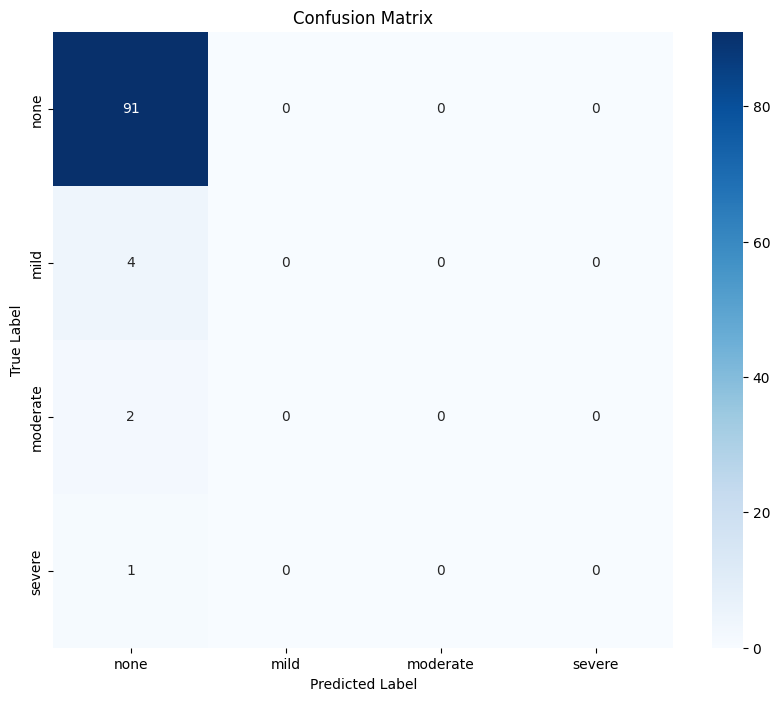


Classification Report:
              precision    recall  f1-score   support

        none       0.93      1.00      0.96        91
        mild       0.00      0.00      0.00         4
    moderate       0.00      0.00      0.00         2
      severe       0.00      0.00      0.00         1

    accuracy                           0.93        98
   macro avg       0.23      0.25      0.24        98
weighted avg       0.86      0.93      0.89        98


Task 2 completed. Model saved as 'best_model.pt'


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [36]:
# Import common libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import re

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Common Dataset Class
class SeverityDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# ===== TASK 2: BioClinicalBERT Classification =====

def prepare_data(file_path='M3S-Radiology-Reports.csv'):
    """Prepare data for document-level classification"""
    # Read the CSV file
    df = pd.read_csv(file_path)

    # Print info about the dataset
    print("\nDataset Info:")
    print(df.info())
    print("\nSample of data:")
    print(df.head())

    # Handle empty values in severity_label
    df['severity_label'] = df['severity_label'].fillna('none')

    # Convert severity labels to numeric values
    severity_map = {'none': 0, 'mild': 1, 'moderate': 2, 'severe': 3}
    df['label'] = df['severity_label'].map(severity_map)

    # Check for any NaN values in label column
    if df['label'].isna().any():
        print("\nWarning: Found NaN values in label column after mapping.")
        print("Unique values in severity_label:", df['severity_label'].unique())
        # Fill NaN values with 0 (none)
        df['label'] = df['label'].fillna(0)

    # Check label distribution
    print("\nLabel Distribution:")
    print(df['severity_label'].value_counts())

    # Split the data
    train_df, test_df = train_test_split(
        df,
        test_size=0.2,
        random_state=42,
        stratify=df['label']
    )

    print(f"\nTraining set size: {len(train_df)}")
    print(f"Test set size: {len(test_df)}")

    return train_df, test_df, df

def train_model(model, train_loader, val_loader, epochs=3):
    """Train the model and return training history"""
    optimizer = AdamW(model.parameters(), lr=2e-5)
    best_accuracy = 0
    history = {'train_loss': [], 'val_accuracy': []}

    for epoch in range(epochs):
        print(f'\nEpoch {epoch + 1}/{epochs}')

        # Training
        model.train()
        total_loss = 0
        progress_bar = tqdm(train_loader, desc='Training')

        for batch in progress_bar:
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

            progress_bar.set_postfix({'loss': loss.item()})

        avg_train_loss = total_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # Validation
        accuracy = evaluate_model(model, val_loader)
        history['val_accuracy'].append(accuracy)

        print(f'Average training loss: {avg_train_loss:.4f}')
        print(f'Validation accuracy: {accuracy:.4f}')

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            # Save the best model
            torch.save(model.state_dict(), 'best_model.pt')
            print(f"Saved best model with accuracy: {accuracy:.4f}")

    return history

def evaluate_model(model, data_loader):
    """Evaluate the model and return accuracy"""
    model.eval()
    correct = 0
    total = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return correct / total

def plot_confusion_matrix(true_labels, predictions):
    """Plot confusion matrix and print classification report"""
    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['none', 'mild', 'moderate', 'severe'],
                yticklabels=['none', 'mild', 'moderate', 'severe'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(true_labels, predictions,
                              target_names=['none', 'mild', 'moderate', 'severe']))

def task2_main():
    """Main function for Task 2: Document-Level Classification"""
    print("\n===== TASK 2: Document-Level Severity Classification =====")

    # 1. Prepare data
    train_df, test_df, full_df = prepare_data('M3S-Radiology-Reports.csv')

    # 2. Initialize tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
    model = AutoModelForSequenceClassification.from_pretrained(
        'emilyalsentzer/Bio_ClinicalBERT',
        num_labels=4  # 4 labels: none, mild, moderate, severe
    ).to(device)

    # 3. Create datasets
    train_dataset = SeverityDataset(
        train_df['text'].values,
        train_df['label'].values,
        tokenizer
    )
    test_dataset = SeverityDataset(
        test_df['text'].values,
        test_df['label'].values,
        tokenizer
    )

    # 4. Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=16,
        shuffle=True
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=16
    )

    # 5. Train the model
    print("\nStarting training...")
    history = train_model(model, train_loader, test_loader)

    # 6. Final evaluation
    print("\nPerforming final evaluation...")
    final_accuracy = evaluate_model(model, test_loader)
    print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")

    # 7. Generate predictions for confusion matrix
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label']

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, predicted = torch.max(outputs.logits, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    # 8. Plot confusion matrix
    plot_confusion_matrix(all_labels, all_predictions)

    # Save results
    print("\nTask 2 completed. Model saved as 'best_model.pt'")

    # Return model and tokenizer for potential use in other tasks
    return model, tokenizer, full_df

# Run Task 2
if __name__ == "__main__":
    task2_main()

TASK 3: Cascading Classification and Entity Identification

In [44]:
# Install and load necessary libraries
!pip install transformers spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 57.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [43]:


import re
import torch
import spacy
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the fine-tuned BioClinicalBERT model and tokenizer.
model_name = "emilyalsentzer/Bio_ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
try:
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=4
    ).to(device)
    model.load_state_dict(torch.load("best_model.pt"))
    print("Loaded fine-tuned model from 'best_model.pt'")
except Exception as e:
    print("Could not load best_model.pt. Loading pretrained model.")
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=4
    ).to(device)

# Mapping from numeric label to severity string.
severity_map = {0: "none", 1: "mild", 2: "moderate", 3: "severe"}

def predict_severity(text):
    """Tokenizes the input text and predicts severity."""
    inputs = tokenizer(
        text, return_tensors="pt", truncation=True, padding=True, max_length=256
    ).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    predicted_label = torch.argmax(outputs.logits, dim=1).item()
    return severity_map[predicted_label]

# Load spaCy for entity extraction.
nlp = spacy.load("en_core_web_sm")
def extract_candidate_entities(text):
    """
    Uses spaCy to extract noun chunks as candidate entities.
    Returns a list of unique candidate strings.
    """
    doc = nlp(text)
    candidates = set()
    for chunk in doc.noun_chunks:
        # We only want reasonably short candidates.
        if len(chunk.text.split()) <= 4:
            candidates.add(chunk.text.strip())
    return list(candidates)

def clean_candidate(candidate):
    """
    Remove common severity adjectives from the candidate.
    For example, "a mild stenosis" becomes "stenosis".
    """
    severity_words = ["mild", "moderate", "severe"]
    # Remove each severity word (case insensitive) and also articles "a", "an", "the"
    candidate = re.sub(r'\b(a|an|the)\b', '', candidate, flags=re.IGNORECASE)
    for word in severity_words:
        candidate = re.sub(r'\b' + word + r'\b', '', candidate, flags=re.IGNORECASE)
    # Remove extra whitespace
    return " ".join(candidate.split()).strip()

def highlight_candidate(text, candidate):
    """
    Replace the first occurrence of the candidate in text with a highlighted version.
    """
    candidate_escaped = re.escape(candidate)
    pattern = re.compile(candidate_escaped, re.IGNORECASE)
    highlighted_text = pattern.sub(f"[ENTITY]{candidate}[/ENTITY]", text, count=1)
    return highlighted_text

def test_entity_severity(text, expected_overall_severity="mild"):
    """
    Given a text (without entity markers) and its overall severity,
    extract candidate entities, clean them, highlight each, and predict severity.
    """
    print("Original text:\n", text, "\n")
    candidates = extract_candidate_entities(text)
    print("Candidate entities found (raw):")
    for c in candidates:
        print(" -", c)

    # Clean candidates to remove severity adjectives, etc.
    cleaned_candidates = [clean_candidate(c) for c in candidates]
    print("\nCleaned candidate entities:")
    for c in cleaned_candidates:
        print(" -", c)

    print("\nPredicting severity for each candidate by highlighting it...")
    results = []
    for candidate in cleaned_candidates:
        mod_text = highlight_candidate(text, candidate)
        pred = predict_severity(mod_text)
        results.append((candidate, pred))
        print(f"Candidate: '{candidate}' -> Predicted severity: {pred}")

    mild_candidates = [cand for cand, sev in results if sev.lower() == expected_overall_severity.lower()]
    print("\nCandidates predicted as", expected_overall_severity + ":", mild_candidates)
    return results

# Example usage.
sample_text = "There is a mild stenosis in the right internal carotid artery approximately 2."
results = test_entity_severity(sample_text, expected_overall_severity="mild")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 63.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded fine-tuned model from 'best_model.pt'
Original text:
 There is a mild stenosis in the right internal carotid artery approximately 2. 

Candidate entities found (raw):
 - a mild stenosis

Cleaned candidate entities:
 - stenosis

Predicting severity for each candidate by highlighting it...
Candidate: 'stenosis' -> Predicted severity: none

Candidates predicted as mild: []


TASK 4: Few-Shot Learning for Entity-Level Classification


===== TASK 4: Few-Shot Learning for Entity-Level Classification =====
Loaded entity data with 363 records.

Preparing examples for few-shot learning...
Selected 17 examples for few-shot learning.

Performing binary few-shot classification (severe vs. not severe)...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Fine-tuning binary model (3 epochs)...
Epoch 1/3, Average Loss: 0.3717
Epoch 2/3, Average Loss: 0.2860
Epoch 3/3, Average Loss: 0.2171

Predicting on query entities (binary)...

Binary classification accuracy: 1.0000

Binary classification results (first 5 examples):
Entity: bilateral infiltrates
Is severe: False
True label: none
---
Entity: pleural effusion
Is severe: False
True label: none
---
Entity: bilateral pleural
Is severe: False
True label: none
---
Entity: diffuse edema
Is severe: False
True label: mild
---
Entity: right pleural
Is severe: False
True label: none
---

Performing multiclass few-shot classification...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Fine-tuning multiclass model (3 epochs)...
Epoch 1/3, Average Loss: 1.7486
Epoch 2/3, Average Loss: 1.2639
Epoch 3/3, Average Loss: 1.1831

Predicting on query entities (multiclass)...

Multiclass classification accuracy: 0.1000


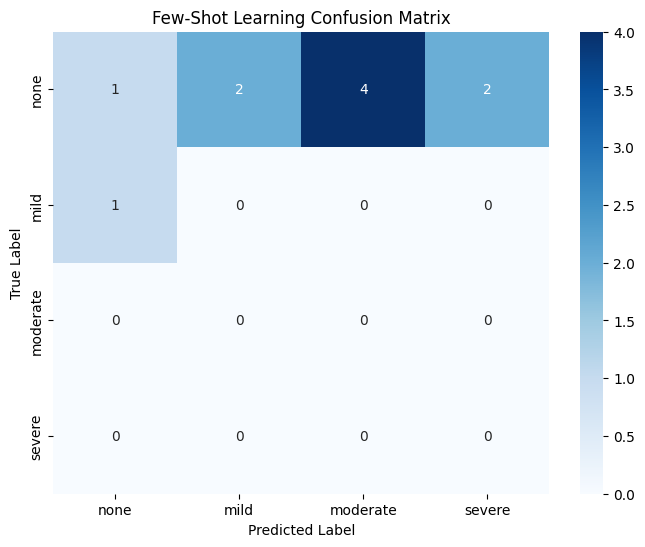


Multiclass classification results (first 5 examples):
Entity: bilateral infiltrates
Predicted severity: moderate
True label: none
---
Entity: pleural effusion
Predicted severity: moderate
True label: none
---
Entity: bilateral pleural
Predicted severity: mild
True label: none
---
Entity: diffuse edema
Predicted severity: none
True label: mild
---
Entity: right pleural
Predicted severity: mild
True label: none
---

Task 4: Few-Shot Learning completed.


In [45]:
# ===== TASK 4: Few-Shot Learning for Entity-Level Classification =====

# Import necessary libraries
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import os

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class FewShotDataset(Dataset):
    """Dataset for few-shot learning"""
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

def prepare_few_shot_examples(entity_df, n_examples=5):
    """Prepare examples for few-shot learning from the entity dataframe."""
    examples = []
    severity_classes = ['none', 'mild', 'moderate', 'severe']
    for severity in severity_classes:
        class_df = entity_df[entity_df['doc_severity'] == severity]
        if len(class_df) > 0:
            n = min(n_examples, len(class_df))
            selected = class_df.sample(n)
            for _, row in selected.iterrows():
                examples.append({
                    'text': row['context'],
                    'entity': row['entity'],
                    'label': severity
                })
    return examples

def load_saved_model(num_labels):
    """
    Load a BioClinicalBERT model.
    For multiclass (num_labels=4), load the entire saved model.
    For binary (num_labels=2), load the encoder weights from the saved 4-label model.
    """
    model = AutoModelForSequenceClassification.from_pretrained('emilyalsentzer/Bio_ClinicalBERT', num_labels=num_labels)
    if os.path.exists('best_model.pt'):
        saved_state = torch.load('best_model.pt', map_location=device)
        if num_labels == 4:
            # For multiclass, load the complete state dict.
            model.load_state_dict(saved_state)
        else:
            # For binary, load encoder weights only (skip keys from the classifier head).
            filtered_state = {k: v for k, v in saved_state.items() if not k.startswith('classifier')}
            model.load_state_dict(filtered_state, strict=False)
    else:
        print("Saved model not found. Starting from the pretrained checkpoint.")
    return model.to(device)

def few_shot_binary_classification(examples, query_entities, tokenizer):
    """Few-shot binary classification (severe or not) using the saved encoder weights."""
    print("\nPerforming binary few-shot classification (severe vs. not severe)...")
    binary_examples = []
    for ex in examples:
        binary_examples.append({
            'text': ex['text'],
            'entity': ex['entity'],
            'label': 1 if ex['label'] == 'severe' else 0
        })

    # Initialize binary model using saved encoder weights.
    binary_model = load_saved_model(num_labels=2)

    # Prepare fine-tuning data.
    train_texts = [f"{ex['text']} [ENTITY] {ex['entity']}" for ex in binary_examples]
    train_labels = [ex['label'] for ex in binary_examples]
    train_encodings = tokenizer(train_texts, truncation=True, padding=True)
    train_dataset = FewShotDataset(train_encodings, train_labels)
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

    optimizer = AdamW(binary_model.parameters(), lr=5e-5)
    binary_model.train()

    print("\nFine-tuning binary model (3 epochs)...")
    for epoch in range(3):
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = binary_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}/3, Average Loss: {total_loss/len(train_loader):.4f}")

    # Predict on query entities.
    results = []
    binary_model.eval()
    print("\nPredicting on query entities (binary)...")
    for query in query_entities:
        input_text = f"{query['text']} [ENTITY] {query['entity']}"
        inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
        with torch.no_grad():
            outputs = binary_model(**inputs)
            prediction = torch.argmax(outputs.logits, dim=1).item()
        results.append({
            'entity': query['entity'],
            'text': query['text'],
            'is_severe': bool(prediction),
            'true_label': query['true_label']
        })

    # Calculate binary accuracy.
    correct = sum(1 for r in results if (r['is_severe'] and r['true_label'] == 'severe') or
                                        (not r['is_severe'] and r['true_label'] != 'severe'))
    accuracy = correct / len(results)
    print(f"\nBinary classification accuracy: {accuracy:.4f}")
    return results

def few_shot_multiclass_classification(examples, query_entities, tokenizer):
    """Few-shot multiclass classification (none, mild, moderate, severe) using the saved model."""
    print("\nPerforming multiclass few-shot classification...")
    # Load the fully fine-tuned multiclass model.
    multiclass_model = load_saved_model(num_labels=4)

    severity_map = {'none': 0, 'mild': 1, 'moderate': 2, 'severe': 3}
    reverse_map = {0: 'none', 1: 'mild', 2: 'moderate', 3: 'severe'}

    train_texts = [f"{ex['text']} [ENTITY] {ex['entity']}" for ex in examples]
    train_labels = [severity_map[ex['label']] for ex in examples]
    train_encodings = tokenizer(train_texts, truncation=True, padding=True)
    train_dataset = FewShotDataset(train_encodings, train_labels)
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

    optimizer = AdamW(multiclass_model.parameters(), lr=5e-5)
    multiclass_model.train()

    print("\nFine-tuning multiclass model (3 epochs)...")
    for epoch in range(3):
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = multiclass_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}/3, Average Loss: {total_loss/len(train_loader):.4f}")

    # Predict on query entities.
    results = []
    true_labels = []
    predicted_labels = []
    multiclass_model.eval()
    print("\nPredicting on query entities (multiclass)...")
    for query in query_entities:
        input_text = f"{query['text']} [ENTITY] {query['entity']}"
        inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
        with torch.no_grad():
            outputs = multiclass_model(**inputs)
            prediction = torch.argmax(outputs.logits, dim=1).item()
        predicted_severity = reverse_map[prediction]
        results.append({
            'entity': query['entity'],
            'text': query['text'],
            'severity': predicted_severity,
            'true_label': query['true_label']
        })
        true_labels.append(severity_map[query['true_label']])
        predicted_labels.append(prediction)

    correct = sum(1 for r in results if r['severity'] == r['true_label'])
    accuracy = correct / len(results)
    print(f"\nMulticlass classification accuracy: {accuracy:.4f}")

    # Plot confusion matrix.
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['none', 'mild', 'moderate', 'severe'],
                yticklabels=['none', 'mild', 'moderate', 'severe'])
    plt.title('Few-Shot Learning Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return results

def task4_main():
    """Main function for Task 4: Few-Shot Learning for Entity-Level Classification using the saved model."""
    print("\n===== TASK 4: Few-Shot Learning for Entity-Level Classification =====")

    # 1. Load tokenizer.
    tokenizer = AutoTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')

    # 2. Load entity data.
    try:
        entity_df = pd.read_csv('entity_predictions.csv')
        print(f"Loaded entity data with {len(entity_df)} records.")
    except:
        try:
            df = pd.read_csv('M3S-Radiology-Reports.csv')
            print("Entity predictions not found. Please run Task 3 first.")
            print("Using a simplified example from the original dataset.")
            entity_df = pd.DataFrame({
                'entity': ['lung', 'heart', 'pleural effusion', 'pneumonia'],
                'context': [
                    'The lung fields are clear without evidence of consolidation.',
                    'The heart size appears normal.',
                    'Small pleural effusion is noted in the right lung base.',
                    'Bilateral pneumonia is present in both lower lobes.'
                ],
                'doc_severity': ['none', 'none', 'mild', 'moderate']
            })
        except:
            print("Dataset files not found. Please run Tasks 2 and 3 first.")
            return

    # 3. Prepare few-shot examples.
    print("\nPreparing examples for few-shot learning...")
    examples = prepare_few_shot_examples(entity_df)
    print(f"Selected {len(examples)} examples for few-shot learning.")

    # 4. Select query entities to classify.
    query_entities = []
    if len(entity_df) >= 10:
        test_entities = entity_df.sample(10)
        for _, row in test_entities.iterrows():
            query_entities.append({
                'entity': row['entity'],
                'text': row['context'] if 'context' in row else row['text'],
                'true_label': row['doc_severity']
            })
    else:
        for _, row in entity_df.iterrows():
            query_entities.append({
                'entity': row['entity'],
                'text': row['context'] if 'context' in row else row['text'],
                'true_label': row['doc_severity']
            })

    # 5. Run binary few-shot classification.
    binary_results = few_shot_binary_classification(examples, query_entities, tokenizer)
    print("\nBinary classification results (first 5 examples):")
    for i, result in enumerate(binary_results[:5]):
        print(f"Entity: {result['entity']}")
        print(f"Is severe: {result['is_severe']}")
        print(f"True label: {result['true_label']}")
        print("---")

    # 6. Run multiclass few-shot classification.
    multiclass_results = few_shot_multiclass_classification(examples, query_entities, tokenizer)
    print("\nMulticlass classification results (first 5 examples):")
    for i, result in enumerate(multiclass_results[:5]):
        print(f"Entity: {result['entity']}")
        print(f"Predicted severity: {result['severity']}")
        print(f"True label: {result['true_label']}")
        print("---")

    print("\nTask 4: Few-Shot Learning completed.")

if __name__ == "__main__":
    task4_main()
